# Model selection with decoding accuracy and loss

_Hypothesis testing approach_

* **Authors**:  
  
  * Author: steeve.laquitaine@nepfl.ch; laquitainesteeve@gmail.com.
  * Adapted from notebooks by Steffen Schneider, Jin H Lee, Mackenzie Mathis.  
  * Duration: 1h36 (max_iterations=5000)

* **Learning outcomes**:

  * know how to <u>decode labels</u> from a CEBRA manifold with the `kNN`
  technique.
  * know how to ensure <u>robust decoding</u> with `cross-validation`.
  * know how to <u>evaluate and compare the decoding performances</u> for neural manifolds obtained from different hypotheses with `decoding median error` and `InfoNCE loss`.

* **Readings**:

  * Schneider, S., Lee, J. H., & Mathis, M. W. (2023). Learnable latent embeddings for joint behavioural and neural analysis. Nature, 617(7960), 360-368. see [Figure 2.d.](https://cebra.ai/docs/cebra-figures/figures/Figure2.html) of Schneider, Lee, Mathis.

* **Python prerequisites**:

  * installing and importing `libraries`
  * plotting with `matplotlib` library

## (5m) Setup

1. Install `Cebra` with Python's pip software package manager (requires internet connection).
2. Import `software packages` (requires internet connection)

In [ ]:
import time
import locale
t0 = time.time()
locale.getpreferredencoding = lambda: "UTF-8"
!pip install -q ipython-autotime # time track colab notebook cells
!pip install -q --pre 'cebra[datasets,demos]'
%load_ext autotime

In [ ]:
# import software packages
import sys
import numpy as np
import matplotlib.pyplot as plt
import cebra
import cebra.datasets
from cebra import CEBRA
import sklearn.metrics

time: 11.7 s (started: 2024-03-22 08:28:30 +00:00)


In [ ]:
# custom functions
def split_data(data, test_ratio):

  split_idx = int(len(data)* (1-test_ratio))
  neural_train = data.neural[:split_idx]
  neural_test = data.neural[split_idx:]
  label_train = data.continuous_index[:split_idx]
  label_test = data.continuous_index[split_idx:]

  return neural_train.numpy(), neural_test.numpy(), label_train.numpy(), label_test.numpy()

def decoding_pos_dir(embedding_train, embedding_test, label_train, label_test):
  """decoding using a k-Nearest Neighbor clustering technique
  For a simple demo, we will use the fixed number of neighbors 36.
  """
  pos_decoder = cebra.KNNDecoder(n_neighbors=36, metric="cosine")
  dir_decoder = cebra.KNNDecoder(n_neighbors=36, metric="cosine")

  pos_decoder.fit(embedding_train, label_train[:,0])
  dir_decoder.fit(embedding_train, label_train[:,1])

  pos_pred = pos_decoder.predict(embedding_test)
  dir_pred = dir_decoder.predict(embedding_test)

  prediction = np.stack([pos_pred, dir_pred],axis = 1)

  test_score = sklearn.metrics.r2_score(label_test[:,:2], prediction)
  pos_test_err = np.median(abs(prediction[:,0] - label_test[:, 0]))
  pos_test_score = sklearn.metrics.r2_score(label_test[:, 0], prediction[:,0])

  return test_score, pos_test_err, pos_test_score

time: 1.7 ms (started: 2024-03-22 08:28:42 +00:00)


## (10s) Dataset

- We analyse a single rat, `achilles`.
- The data will be automatically downloaded into a `/data` folder.

### Load

In [ ]:
hippocampus_pos = cebra.datasets.init('rat-hippocampus-single-achilles')

100%|██████████| 10.0M/10.0M [00:00<00:00, 28.8MB/s]


Download complete. Dataset saved in 'data/rat_hippocampus/achilles.jl'
time: 1.18 s (started: 2024-03-22 08:28:42 +00:00)


### Split into train and test

In [ ]:
neural_train, neural_test, label_train, label_test = split_data(hippocampus_pos, 0.2)

time: 23.5 ms (started: 2024-03-22 08:28:43 +00:00)


## (1s) Parametrize

In [ ]:
max_iterations = 5000 #10000 # default is 5000.
output_dimension = 32  # here, we set as a variable for hypothesis testing below.

cebra_posdir_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=output_dimension,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

cebra_pos_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=output_dimension,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

cebra_dir_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=output_dimension,
                        max_iterations=max_iterations,
                        distance='cosine',
                        device='cuda_if_available',
                        verbose=True)

time: 8.44 ms (started: 2024-03-22 08:28:43 +00:00)


## (45m) Train the models

- For a quick CPU run-time demo, you can drop `max_iterations` to 100-500; otherwise set to 5000.

- We will train CEBRA-Behavior with position, or direction, and/or both variables


In [ ]:
# Train with both position and direction variables.
cebra_posdir_model.fit(neural_train, label_train)
cebra_posdir_model.save("cebra_posdir_model.pt")

# Train with position
cebra_pos_model.fit(neural_train, label_train[:,0])
cebra_pos_model.save("cebra_pos_model.pt")

# Train with direction
cebra_dir_model.fit(neural_train, label_train[:,1])
cebra_dir_model.save("cebra_dir_model.pt")

pos: -0.8778 neg:  6.3900 total:  5.5122 temperature:  1.0000: 100%|██████████| 5000/5000 [15:42<00:00,  5.30it/s]
pos: -0.8876 neg:  6.4874 total:  5.5997 temperature:  1.0000: 100%|██████████| 5000/5000 [15:38<00:00,  5.33it/s]
pos: -0.8202 neg:  6.4762 total:  5.6560 temperature:  1.0000: 100%|██████████| 5000/5000 [15:00<00:00,  5.55it/s]

time: 46min 25s (started: 2024-03-22 08:28:43 +00:00)



## (50m) Controls

- We will train shuffled CEBRA-Behavior with position, direction variables and both

### (1s) Parametrize

In [ ]:
cebra_posdir_shuffled_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=output_dimension,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

cebra_pos_shuffled_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=output_dimension,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

cebra_dir_shuffled_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=output_dimension,
                        max_iterations=max_iterations,
                        distance='cosine',
                        device='cuda_if_available',
                        verbose=True)

time: 1.95 ms (started: 2024-03-22 09:15:09 +00:00)


### (50m) Train

In [ ]:
# Generate shuffled behavior labels for train set.
shuffled_posdir = np.random.permutation(label_train)
shuffled_pos = np.random.permutation(label_train[:,0])
shuffled_dir = np.random.permutation(label_train[:,1])

# Train the models with shuffled behavior variables
cebra_posdir_shuffled_model.fit(neural_train, shuffled_posdir)
cebra_posdir_shuffled_model.save("cebra_posdir_shuffled_model.pt")

cebra_pos_shuffled_model.fit(neural_train, shuffled_pos)
cebra_pos_shuffled_model.save("cebra_pos_shuffled_model.pt")

cebra_dir_shuffled_model.fit(neural_train, shuffled_dir)
cebra_dir_shuffled_model.save("cebra_dir_shuffled_model.pt")

pos: -0.4933 neg:  6.6067 total:  6.1134 temperature:  1.0000: 100%|██████████| 5000/5000 [15:21<00:00,  5.42it/s]
pos: -0.4354 neg:  6.5592 total:  6.1238 temperature:  1.0000: 100%|██████████| 5000/5000 [15:12<00:00,  5.48it/s]
pos: -0.5140 neg:  6.5129 total:  5.9989 temperature:  1.0000: 100%|██████████| 5000/5000 [18:15<00:00,  4.57it/s]


time: 48min 49s (started: 2024-03-22 09:15:09 +00:00)


## (1s) Get the train & test manifolds


In [ ]:
# We get train set embedding and test set embedding.

cebra_posdir_model = cebra.CEBRA.load("cebra_posdir_model.pt")
cebra_posdir_train = cebra_posdir_model.transform(neural_train)
cebra_posdir_test = cebra_posdir_model.transform(neural_test)

cebra_pos_model = cebra.CEBRA.load("cebra_pos_model.pt")
cebra_pos_train = cebra_pos_model.transform(neural_train)
cebra_pos_test = cebra_pos_model.transform(neural_test)

cebra_dir_model = cebra.CEBRA.load("cebra_dir_model.pt")
cebra_dir_train = cebra_dir_model.transform(neural_train)
cebra_dir_test = cebra_dir_model.transform(neural_test)

# ... and similarily for models with shuffled variables

cebra_posdir_shuffled_model = cebra.CEBRA.load("cebra_posdir_shuffled_model.pt")
cebra_posdir_shuffled_train = cebra_posdir_shuffled_model.transform(neural_train)
cebra_posdir_shuffled_test = cebra_posdir_shuffled_model.transform(neural_test)

cebra_pos_shuffled_model = cebra.CEBRA.load("cebra_pos_shuffled_model.pt")
cebra_pos_shuffled_train = cebra_pos_shuffled_model.transform(neural_train)
cebra_pos_shuffled_test = cebra_pos_shuffled_model.transform(neural_test)

cebra_dir_shuffled_model = cebra.CEBRA.load("cebra_dir_shuffled_model.pt")
cebra_dir_shuffled_train = cebra_dir_shuffled_model.transform(neural_train)
cebra_dir_shuffled_test = cebra_dir_shuffled_model.transform(neural_test)

# .. and for the entire dataset
cebra_pos_all = cebra_pos_model.transform(hippocampus_pos.neural)
cebra_dir_all = cebra_dir_model.transform(hippocampus_pos.neural)
cebra_posdir_all = cebra_posdir_model.transform(hippocampus_pos.neural)

cebra_pos_shuffled_all = cebra_pos_shuffled_model.transform(hippocampus_pos.neural)
cebra_dir_shuffled_all = cebra_dir_shuffled_model.transform(hippocampus_pos.neural)
cebra_posdir_shuffled_all = cebra_posdir_shuffled_model.transform(hippocampus_pos.neural)

time: 443 ms (started: 2024-03-22 10:03:58 +00:00)


## (5s) Decode the labels from the manifolds (kNN)

- We will evaluate the decoding performance of the different model hypotheses.

### (3s) Position and direction

- We used the models trained on the train portion of the dataset to decode position, direction only, and position and directions from the test portion of the dataset.

In [ ]:
# decode from actual data

# position only
cebra_pos_decode = decoding_pos_dir(cebra_pos_train, cebra_pos_test, label_train, label_test)

# direction only
cebra_dir_decode = decoding_pos_dir(cebra_dir_train, cebra_dir_test, label_train, label_test)

# position and direction
cebra_posdir_decode = decoding_pos_dir(cebra_posdir_train, cebra_posdir_test, label_train, label_test)

# controls
cebra_pos_shuffled_decode = decoding_pos_dir(cebra_pos_shuffled_train, cebra_pos_shuffled_test, label_train, label_test)
cebra_dir_shuffled_decode = decoding_pos_dir(cebra_dir_shuffled_train, cebra_dir_shuffled_test, label_train, label_test)
cebra_posdir_shuffled_decode = decoding_pos_dir(cebra_posdir_shuffled_train, cebra_posdir_shuffled_test, label_train, label_test)

time: 3.68 s (started: 2024-03-22 10:03:59 +00:00)


### (1s) Plot

- We plot the decoding results and loss.

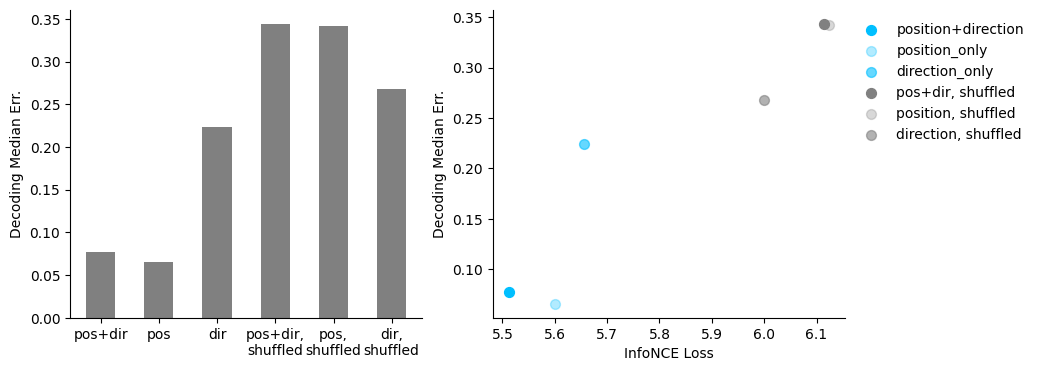

time: 660 ms (started: 2024-03-22 10:04:02 +00:00)


In [ ]:
fig = plt.figure(figsize=(10,4))

# plot the decoding median error for each hypothesis
ax1 = plt.subplot(121)
ax1.bar(x = np.arange(6),
        height = [cebra_posdir_decode[1], cebra_pos_decode[1], cebra_dir_decode[1],
                cebra_posdir_shuffled_decode[1], cebra_pos_shuffled_decode[1], cebra_dir_shuffled_decode[1]
                ],
        width = 0.5,
        color = 'gray'
        )

# legend
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_xticks(np.arange(6))
ax1.set_xticklabels(['pos+dir', 'pos', 'dir', 'pos+dir,\nshuffled', 'pos,\nshuffled', 'dir,\nshuffled'])
ax1.set_ylabel('Decoding Median Err.')

# plot the decoding median error against the infoNCE loss
ax2 = plt.subplot(122)
ax2.scatter(cebra_posdir_model.state_dict_['loss'][-1],cebra_posdir_decode[1], s=50, c='deepskyblue', label = 'position+direction')
ax2.scatter(cebra_pos_model.state_dict_['loss'][-1],cebra_pos_decode[1], s=50, c='deepskyblue', alpha = 0.3, label = 'position_only')
ax2.scatter(cebra_dir_model.state_dict_['loss'][-1],cebra_dir_decode[1], s=50, c='deepskyblue', alpha=0.6,label = 'direction_only')
ax2.scatter(cebra_posdir_shuffled_model.state_dict_['loss'][-1],cebra_posdir_shuffled_decode[1], s=50, c='gray', label = 'pos+dir, shuffled')
ax2.scatter(cebra_pos_shuffled_model.state_dict_['loss'][-1],cebra_pos_shuffled_decode[1], s=50, c='gray', alpha = 0.3, label = 'position, shuffled')
ax2.scatter(cebra_dir_shuffled_model.state_dict_['loss'][-1],cebra_dir_shuffled_decode[1], s=50, c='gray', alpha=0.6,label = 'direction, shuffled')

# legend
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_xlabel('InfoNCE Loss')
ax2.set_ylabel('Decoding Median Err.')
plt.legend(bbox_to_anchor=(1,1), frameon = False )
plt.show()

In [ ]:
print("The notebook execution took:", np.round(time.time() - t0),1)

The notebook execution took: 5881.0 1
time: 3.33 ms (started: 2024-03-22 10:04:03 +00:00)
